In [1]:
# Import the necessary libraries

import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance


from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)

import pickle

## Data Wrangling

In [2]:
# Establish the path to read all of the images 

path_training_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/flip/*.jpg')

path_training_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/notflip/*.jpg')

path_testing_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/flip/*.jpg')

path_testing_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/notflip/*.jpg')

In [3]:
# Define a function to read the jpg images

def image_reader(im):
    image = cv2.imread(im)
    return image

In [4]:
# Apply numba to reduce computational time

jitted_function = njit(nopython = True) (image_reader)

In [5]:
# Read the training file for flip

cv_img_training_flip = np.array([image_reader(im = i) for i in path_training_flip])

# Read the training for notflip

cv_img_training_notflip = np.array([image_reader(im = i) for i in path_training_notflip])

# Read testing for flip

cv_img_testing_flip = np.array([image_reader(im = i) for i in path_testing_flip])
    
# Read testing for notflip

cv_img_testing_notflip = np.array([image_reader(im = i) for i in path_testing_notflip])


In [6]:
# Define the labels for the problem

y_train_flip = [1 for i in range(0, len(cv_img_training_flip))]

y_train_notflip = [0 for i in range(0, len(cv_img_training_notflip))]

y_test_flip = [1 for i in range(0, len(cv_img_testing_flip))]

y_test_notflip = [0 for i in range(0, len(cv_img_testing_notflip))]

### Data Preprocessing

In [7]:
# Adjust the size to be uniform in all the images for train data set

adjusted_flip_train = np.array([cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC) for i in cv_img_training_flip])


adjusted_notflip_train = np.array([cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC) for i in cv_img_training_notflip])


In [8]:
# Adjust the size on the test dataset

adjusted_flip_test = np.array([cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC) for i in cv_img_testing_flip])


adjusted_notflip_test = np.array([cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC) for i in cv_img_testing_notflip])

In [9]:
# Set the values to crop the images

y = 0
h = 100
x = 0
w = 70

# Adjust to crop on train data setjust to take into account the image I am interested

crop_flip_train = np.array([i[y:y+h, x:x+w] for i in adjusted_flip_train])
                     
crop_notflip_train = np.array([i[y:y+h, x:x+w] for i in adjusted_notflip_train])

In [10]:
# Adjust to crop on test data set just to take into account the image I am interested

crop_flip_test = np.array([i[y:y+h, x:x+w] for i in adjusted_flip_test])
                     
crop_notflip_test = np.array([i[y:y+h, x:x+w] for i in adjusted_notflip_test])

In [11]:
# Define an alpha and beta for contrast and brightness

def adjust_contrast_brightness(im):
    alpha=1.5
    beta=0.5
    image = cv2.addWeighted(im, alpha, np.zeros(im.shape, im.dtype), 0, beta)
    return image



In [12]:
# Adjust the bright and the contrast of the train data set

bright_contrast_flip_train = np.array([adjust_contrast_brightness(im = i) for i in crop_flip_train])

bright_contrast_notflip_train = np.array([adjust_contrast_brightness(im = i) for i in crop_notflip_train])

In [13]:
# Adjust the bright and the contrast of the train data set

bright_contrast_flip_test = np.array([adjust_contrast_brightness(im = i) for i in crop_flip_test])

bright_contrast_notflip_test = np.array([adjust_contrast_brightness(im = i) for i in crop_notflip_test])

In [14]:
# Normalize the data to give ranges between 0 and 1

img_reverted_flip_train = np.array([cv2.bitwise_not(i) for i in bright_contrast_flip_train])

img_reverted_notflip_train = np.array([cv2.bitwise_not(i) for i in bright_contrast_notflip_train])

In [15]:
# Normalize the data to give ranges between 0 and 1

img_reverted_flip_test = np.array([cv2.bitwise_not(i) for i in bright_contrast_flip_test])

img_reverted_notflip_test = np.array([cv2.bitwise_not(i) for i in bright_contrast_notflip_test])

In [16]:
# Divide into 255.00 to have the images in black and white scale on the train data set

bw_image_flip_train = img_reverted_flip_train / 255.0

bw_image_notflip_train = img_reverted_notflip_train / 255.0

In [17]:
# Divide into 255.00 to have the images in black and white scale on the test data set

bw_image_flip_test = img_reverted_flip_test / 255.0

bw_image_notflip_test = img_reverted_notflip_test / 255.0

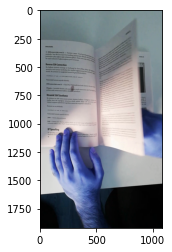

In [18]:
# Original image in black and gray scale

plt.imshow(cv_img_training_flip[0])

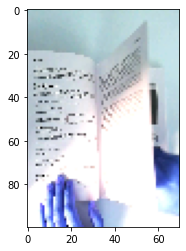

In [19]:
# See the image after adjusting size, contrast, crop 

plt.imshow(bright_contrast_flip_train[0])

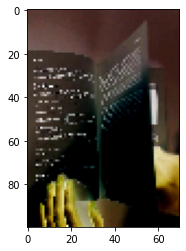

In [20]:
# See image in black and white

plt.imshow(bw_image_flip_train[0])

In [21]:
# Define the X_train, X_test, y_train and y_test for analysis

X_train = np.concatenate((bw_image_flip_train, bw_image_notflip_train), axis = 0)

X_test = np.concatenate((bw_image_flip_test, bw_image_notflip_test), axis = 0)

y_train = np.append(y_train_flip, y_train_notflip)

y_test = np.append(y_test_flip, y_test_notflip)

In [22]:
# See if the shapes matches between the X_trian and y_train and the X_test and y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


In [23]:
# Create a new array that will have the original arrays (labels and values) but they will be shuffled. 

# Create the array for the train data set

X_train_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_train):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_train[i])
    # Append the values to the array that will be shuffled
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)




In [24]:
# Create the array for the test data set

X_test_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_test):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_test[i])
    # Append the values to the array that will be shuffled
    X_test_shuffle.append(new_array)
    
# Have the new set of arrays  
X_test_shuffle = np.array(X_test_shuffle)

In [25]:
# Apply the random shuffle to make the train and test with no specific order

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)



In [26]:
# Separate between the X_train and y_train to fit the model

X_train = []
y_train = []

# Start a for loop into the X_train_shuffle
for i in X_train_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_train.append(value)
    y_train.append(label)

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)

In [27]:
# Same for the test data set

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(value)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)

In [28]:
# Make sure labels are same than the first shapes

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


## Modeling

In [29]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# Fit model

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15)

Epoch 1/15
75/75 [==============================] - 17s 230ms/step - loss: 0.3663 - accuracy: 0.8428
Epoch 2/15
75/75 [==============================] - 14s 184ms/step - loss: 0.1442 - accuracy: 0.9624
Epoch 3/15
75/75 [==============================] - 20s 267ms/step - loss: 0.1039 - accuracy: 0.9699
Epoch 4/15
75/75 [==============================] - 12s 158ms/step - loss: 0.0734 - accuracy: 0.9804
Epoch 5/15
75/75 [==============================] - 16s 219ms/step - loss: 0.0504 - accuracy: 0.9895
Epoch 6/15
75/75 [==============================] - 11s 147ms/step - loss: 0.0421 - accuracy: 0.9908
Epoch 7/15
75/75 [==============================] - 10s 127ms/step - loss: 0.0333 - accuracy: 0.9950
Epoch 8/15
75/75 [==============================] - 12s 164ms/step - loss: 0.0247 - accuracy: 0.9992
Epoch 9/15
75/75 [==============================] - 11s 153ms/step - loss: 0.0230 - accuracy: 0.9971
Epoch 10/15
75/75 [==============================] - 9s 127ms/step - loss: 0.0189 - accurac

In [31]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)
        

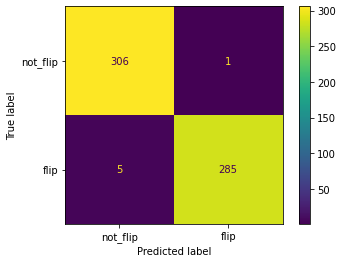

In [32]:
# Display the confusion matrix to evaluate the model

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [33]:
# Print the Classification report to get the precision, recall, f1-score

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       307
           1       1.00      0.98      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



### Conclusion

###### I was able to create a model with 0.99 accuray if a page needs to whether be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the pages the same size, adjusting bright, adding nose, etc.

In [39]:
# Save the model using pickle

model_classifier = model.save('flip_page_classifier')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: flip_page_classifier/assets
